# Determine a comercial website success

> V.A. Suchar
> Stat 504
> 12/14/2015

#### Abstract:

> The purpose of this analysis was to determine if we can predict customers' behavior from readily available information
> collected during the previous year. Also, the company lauched an e-mail campaign to see if it will lead to increased purchases.
> The responses the company was interested were if the customers will visit the website, will make some purchases, and the 
> amount spent by the customers. This may important in the future strategy of the company, when it comes to advertisement, and the type of products it may offer in the future.
> Several models were developed for each response variable (see below).
> Overall, the variables considered had low predictive power for the responses. Probably more information regarding the products customers purchased may improve the models' predictive power.
> Response variable:
>
>    - Visit: 
>          - Best models: loggistic regression, tree and bagging: AUC ~0.64-0.65 
>          - Best features: if customers purchased mens & womens products in the past
>    - Conversion: 
>          - Best models: naive bayes & logistic regression: AUC ~0.53-0.55
>          - Tree, bagging & random forest performe worst than the null model <0.5
>          - Best features: newbie & campaign type
>    - Spend:
>          - Regression analysis: no predictive power & major assumption violations
>Note: since the data is unbalanced,AUC is better suited to asses model performance than accuracy

> Source: http://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html

#### 1. Data description

> This dataset contains 64,000 customers who made purchases within twelve months. 
> 
> Historical customer attributes:
>   - Recency: Months since last purchase.
>   - History_Segment: Categorization of dollars spent in the past year.
>   - History: Actual dollar value spent in the past year.
>   - Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
>   - Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
>   - Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
>   - Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
>   - Channel: Describes the channels the customer purchased from in the past year
>   - E-mail campaign received by the customer: Men-Email, Women E-mail No-email
>
> Response variable:
>   - Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks
>   - Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
>   - Spend: Actual dollars spent in the following two weeks.

#### 2. Objectives: develop models to predict the response variables from the given explanatory variables

#### 3.1. Descriptive statistics 

In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('C:/Users/vasiles/OneDrive/STAT 504 Python/project/dataset2.csv')
print data.head()

print data.describe().transpose()

   recency  history_segment  history  mens  womens   zip_code  newbie channel  \
0       10                2   142.44     1       0  Surburban       0   Phone   
1        6                3   329.08     1       1      Rural       1     Web   
2        7                2   180.65     0       1  Surburban       1     Web   
3        9                5   675.83     1       0      Rural       1     Web   
4        2                1    45.34     1       0      Urban       0     Web   

       segment  visit  conversion  spend  
0  WomensEMail      0           0      0  
1      NoEMail      0           0      0  
2  WomensEMail      0           0      0  
3    MensEMail      0           0      0  
4  WomensEMail      0           0      0  
                 count        mean         std    min    25%     50%  \
recency          64000    5.763734    3.507592   1.00   2.00    6.00   
history_segment  64000    2.481969    1.544514   1.00   1.00    2.00   
history          64000  242.085656  256

#### 3.2 Data preparation

In [2]:
# replace missing values with nan's
df=data.replace(' ', np.NaN)
# drop nan's
df=df.dropna()
df.info()
df['Location'] = df['zip_code'].map( {'Surburban': 0, 'Rural': 1, 'Urban': 2} ).astype(int)
df['Purchase_channel'] = df['channel'].map( {'Phone': 0, 'Web': 1, 'Multichannel': 2} ).astype(int)
df['Campaign_type'] = df['segment'].map( {'NoEMail': 0, 'WomensEMail': 1, 'MensEMail': 2} ).astype(int)

print df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency            64000 non-null int64
history_segment    64000 non-null int64
history            64000 non-null float64
mens               64000 non-null int64
womens             64000 non-null int64
zip_code           64000 non-null object
newbie             64000 non-null int64
channel            64000 non-null object
segment            64000 non-null object
visit              64000 non-null int64
conversion         64000 non-null int64
spend              64000 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 6.3+ MB
   recency  history_segment  history  mens  womens   zip_code  newbie channel  \
0       10                2   142.44     1       0  Surburban       0   Phone   
1        6                3   329.08     1       1      Rural       1     Web   
2        7                2   180.65     0       1  Surburban       1     Web   
3        9        

#### 4. Objective 1: develop models to predict if customers visited website in the following two weeks

In [3]:
X_cols=[ 'recency', 'history', 'mens', 'womens', 'Location', 'newbie', 'Purchase_channel', 'Campaign_type']
X=df[X_cols]
Y=df.visit

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)

print X_train.shape
print X_test.shape

(48000, 8)
(16000, 8)


> 4.0 Null model

In [4]:
from sklearn import metrics
ypred = np.ones(64000)
null_auc = metrics.roc_auc_score(Y, ypred)
accuracy=54606.0/(54606+9394)
print 'Accuracy'
print accuracy
print 'Null AUC'
print null_auc

Accuracy
0.85321875
Null AUC
0.5


> 4.1 Naive Bayes

In [5]:
import time
# measure process time
t0 = time.clock()

print time.clock() - t0, "seconds process time"
nb_time=time.clock() - t0
from sklearn.naive_bayes import MultinomialNB
nb= MultinomialNB()
X = X_train
y = y_train
nb.fit(X, y)
y_pred_rating=nb.predict(X_test)
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
nb_10cv_auc = cross_val_score(nb, X, y, cv=10, scoring='roc_auc')
print nb_10cv_auc
print nb_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
nb_time=time.clock() - t0

3.10926031301e-05 seconds process time
[ 0.57484355  0.57427245  0.58621181  0.57229435  0.57114952  0.56740379
  0.60746276  0.56582181  0.58620172  0.5926447 ]
0.579830647097
0.523988848925 seconds process time


> 4.2 KNN

In [6]:
# measure process time
t0 = time.clock()

from sklearn.neighbors import KNeighborsClassifier

X = X_train
y = y_train
# search for an optimal value of K for KNN
k_range = range(1, 9)
k_val = []
for k in k_range:
   knn = KNeighborsClassifier(n_neighbors=k)
   scores = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
   k_val.append(scores.mean())
print k_val

# plot the values of K for KNN 
import matplotlib.pyplot as plt
plt.plot(k_range, k_val, linewidth=2.0)
plt.xlabel('K ')
plt.ylabel('AUC')
plt.title('KNN: optimal k')
plt.grid(True)

# use optimal k
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X, y)
knn_pred_rating = knn.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
knn_10cv_auc = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
print knn_10cv_auc
print knn_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
knn_time=time.clock() - t0

[0.51404245204716636, 0.52253745382080863, 0.52999663619769133, 0.53644080774165614, 0.54396527572763698, 0.54726508553652653, 0.54821054790569645, 0.54956934383699574]
[ 0.53742186  0.55508026  0.55726286  0.54044283  0.5500802   0.54380452
  0.55294333  0.5344749   0.56750193  0.55668076]
0.549569343837
14.4666269205 seconds process time


> 4.3 Logistic regression

In [7]:
# measure process time
t0 = time.clock()

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print lg_10cv_auc
print lg_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
lg_time=time.clock() - t0

[ 0.64243634  0.64564644  0.64579946  0.61983594  0.61726966  0.62933077
  0.6477608   0.6452407   0.64036973  0.63627114]
0.636996097985
2.34078640136 seconds process time


> 4.4 Tree

[0.55452485033828758, 0.58352027513969129, 0.60687055438713933, 0.616835397320181, 0.62482567478028805, 0.62715018133386624, 0.62329743854372555, 0.61807347277902303]
[ 0.62345351  0.63490229  0.63345464  0.61033628  0.61577279  0.62794634
  0.63519837  0.62234151  0.62899052  0.63910556]
0.627150181334
6.0970738238 seconds process time


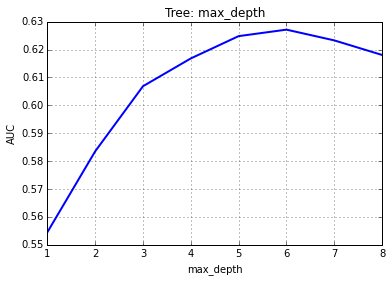

In [8]:
# measure process time
t0 = time.clock()

X = X_train
y = y_train

# optimal depth
from sklearn.tree import DecisionTreeClassifier
depth = range(1, 9)
treedepth = []
for d in depth:
    tree= DecisionTreeClassifier(max_depth = d, random_state =1)
    scores = cross_val_score(tree, X, y, cv=10, scoring='roc_auc')
    treedepth.append(scores.mean())
print treedepth
# plot the values of K for KNN 
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(depth, treedepth, linewidth=2.0)
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.title('Tree: max_depth')
plt.grid(True)

# use optimal depth
tree = DecisionTreeClassifier(max_depth=6, random_state=1)
X = X_train
y = y_train
tree.fit(X,y)
from sklearn.cross_validation import cross_val_score
tree_10cv_auc = cross_val_score(tree, X, y, cv=10, scoring='roc_auc')
print tree_10cv_auc
print tree_10cv_auc.mean()


print time.clock() - t0, "seconds process time"
tree_time=time.clock() - t0

> 4.5 Bagging

[0.62269990852910839, 0.63689777833675354, 0.63701879095338065, 0.636976657304553, 0.63708536295857321, 0.63714653643595287, 0.63718516365081512, 0.63728316472821844, 0.63729544418640494, 0.6373268622158228, 0.63732394255173885]
1986.70788801 seconds process time


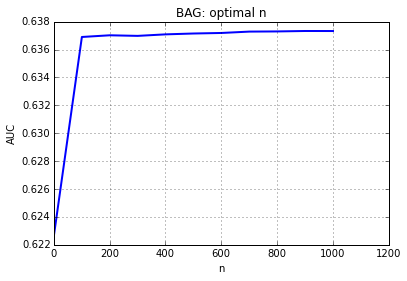

In [9]:
# measure process time
t0 = time.clock()

from sklearn.ensemble import BaggingClassifier
X = X_train
y = y_train

#Find the best no of estimators
bag_n=range(1, 1100, 100)
bag_auc_val= []
for n in bag_n:
    bag=BaggingClassifier(tree,n_estimators=n, random_state=1)
    bag_10cv_auc = cross_val_score(bag, X, y, cv=10, scoring='roc_auc')
    bag_auc_val.append(bag_10cv_auc.mean())
print bag_auc_val

# plot the values of n for Bag 
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bag_n, bag_auc_val, linewidth=2.0)
plt.xlabel('n')
plt.ylabel('AUC')
plt.title('BAG: optimal n')
plt.grid(True)   

print time.clock() - t0, "seconds process time"
bag_time=time.clock() - t0

In [10]:
# measure process time
t0 = time.clock()
# use optimal n
bag=BaggingClassifier(tree,n_estimators=1000, random_state=1)
bag.fit(X,y)
from sklearn.cross_validation import cross_val_score
bag_10cv_auc=cross_val_score(bag, X, y, cv=10, scoring='roc_auc')
print bag_10cv_auc
print bag_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
bag_time=time.clock() - t0

[ 0.63684825  0.64633327  0.64895304  0.61922201  0.62375189  0.62737773
  0.64849773  0.6386744   0.64489154  0.63867333]
0.637322318285
437.24353055 seconds process time


> 4.6 Random Forest

[0.5142770041998237, 0.55893518141289011, 0.5605090469109798, 0.56086663630209865, 0.56109844352732885, 0.56133613713522779, 0.56155114670026918, 0.56156911185625979, 0.56149311181339945, 0.5617117702004738, 0.56175083894418887]
1570.06755879 seconds process time


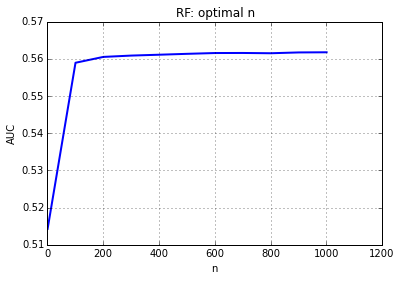

In [11]:
# measure process time
t0 = time.clock()

from sklearn.ensemble import RandomForestClassifier
X = X_train
y = y_train

#Find the best no of estimators
rf_n=range(1, 1100, 100)
rf_auc_val= []
for n in rf_n:
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf_10cv_auc = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
    rf_auc_val.append(rf_10cv_auc.mean())
print rf_auc_val

# plot the no of estimators vc cv_auc
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rf_n, rf_auc_val, linewidth=2.0)
plt.xlabel('n')
plt.ylabel('AUC')
plt.title('RF: optimal n')
plt.grid(True)    

print time.clock() - t0, "seconds process time"
rf_time=time.clock() - t0

In [12]:
# measure process time
t0 = time.clock()
# use optimal n
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, random_state=1)
X = X_train
y = y_train

rf.fit(X,y)
from sklearn.cross_validation import cross_val_score
rf_10cv_auc = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
print rf_10cv_auc
print rf_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
rf_time=time.clock() - t0

[ 0.53944314  0.57003816  0.56608199  0.56101533  0.56302286  0.54599369
  0.57286971  0.5656362   0.56483535  0.56203416]
0.561097057446
121.444907077 seconds process time


> 4.7 SVM Polynomial - (still running... >20 hrs)

In [13]:
# measure process time
#t0 = time.clock()

#from sklearn import svm
#svmp = svm.SVC(kernel='poly', C = 1.0, degree=3)
#X = X_train
#y = y_train
#svmp.fit(X,y)
#from sklearn.cross_validation import cross_val_score
#svmp_10cv_auc = cross_val_score(svmp, X, y, cv=10, scoring='roc_auc')
#print svmp_10cv_auc
#svmp_10cv_auc.mean()

#print time.clock() - t0, "seconds process time"
#svmp_time=time.clock() - t0

4.8 SVM Gaussian

In [14]:
# measure process time
#t0 = time.clock()

#from sklearn import svm
#svmg = svm.SVC(kernel='rbf', C = 1.0, gamma=0.5)
#X = X_train
#y = y_train
#svmg.fit(X,y)
#from sklearn.cross_validation import cross_val_score
#svmg_10cv_auc = cross_val_score(svmg, X, y, cv=10, scoring='roc_auc')
#print svmg_10cv_auc
#svmg_10cv_auc.mean()


#print time.clock() - t0, "seconds process time"
#svmg_time=time.clock() - t0

> 4.9 Tabulate 10cv_auc_means & time

In [15]:
print 'NB 10CV AUC.mean & process time'
print nb_10cv_auc.mean()
print nb_time
print 'KNN 10CV AUC.mean & process time'
print knn_10cv_auc.mean()
print knn_time
print 'LG 10CV AUC.mean & process time'
print lg_10cv_auc.mean()
print lg_time
print 'TREE 10CV AUC.mean & process time'
print tree_10cv_auc.mean()
print tree_time
print 'BAG 10CV AUC.mean & process time'
print bag_10cv_auc.mean()
print bag_time
print 'RF 10CV AUC.mean & process time'
print rf_10cv_auc.mean()
print rf_time
print 'SVMP 10CV AUC.mean & process time'
print 'still running >20hrs'
#print svmp_10cv_auc.mean()
#print svmp_time
print 'SVMG 10CV AUC.mean & process time'
#print svmg_10cv_auc.mean()
#print svmg_time

NB 10CV AUC.mean & process time
0.579830647097
0.524070353807
KNN 10CV AUC.mean & process time
0.549569343837
14.4666755215
LG 10CV AUC.mean & process time
0.636996097985
2.34088088665
TREE 10CV AUC.mean & process time
0.627150181334
6.09712363234
BAG 10CV AUC.mean & process time
0.637322318285
437.243622318
RF 10CV AUC.mean & process time
0.561097057446
121.444963828
SVMP 10CV AUC.mean & process time
still running >20hrs
SVMG 10CV AUC.mean & process time


0.585896788633
0.550306888647
0.645343494916
0.636114073839
0.645427168717
0.578450494852
3.23285129736 seconds process time


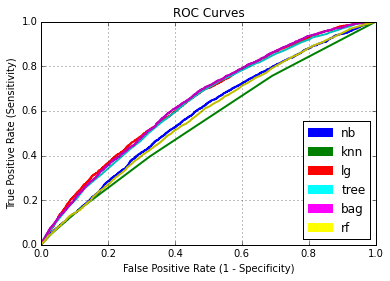

In [16]:
# measure process time
t0 = time.clock()

# If not, use the following; adds also more features....
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
# NB:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
nb_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
nb_fpr, nb_tpr, nb_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# KNN:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
knn_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# LG:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
logreg_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
lg_fpr, lg_tpr, lg_thresholds = metrics.roc_curve(y_test, y_pred_prob)
#TREE:
y_pred_prob = tree.predict_proba(X_test)[:, 1]
tree_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
tree_fpr, tree_tpr, tree_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# BAG:
y_pred_prob = bag.predict_proba(X_test)[:, 1]
bag_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
bag_fpr, bag_tpr, bag_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# RF:
y_pred_prob = rf.predict_proba(X_test)[:, 1]
rf_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(nb_fpr, nb_tpr, knn_fpr, knn_tpr, lg_fpr, lg_tpr, tree_fpr, tree_tpr, bag_fpr, bag_tpr,rf_fpr, rf_tpr, linewidth=2.0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curves')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
nb = mpatches.Patch(color='blue', label='nb')
knn= mpatches.Patch(color='green', label='knn')
lg = mpatches.Patch(color='red', label='lg')
tree = mpatches.Patch(color='cyan', label='tree')
bag = mpatches.Patch(color='magenta', label='bag')
rf = mpatches.Patch(color='yellow', label='rf')
plt.legend(handles=[nb,knn,lg,tree,bag,rf], loc=4)
plt.grid(True)


print time.clock() - t0, "seconds process time"
plot_time=time.clock() - t0

> 4.10 Feature selection
> 
> Recursive feature elimination: recursively removing attributes and building a model on those attributes that remain. 
> It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most 
> to predicting the target attribute.

In [17]:
# Recursive Feature Elimination 3 vars
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
X = X_train
y = y_train
X.shape
model = LogisticRegression()
rfe = RFE(model, 3)
rfe=rfe.fit(X,y)
# summarize the selection of the attributes
print 'Best three features:'
print(rfe.support_)
print(rfe.ranking_)
X_train.head()

# Recursive Feature Elimination 2 vars
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
X = X_train
y = y_train
X.shape
model = LogisticRegression()
rfe = RFE(model, 2)
rfe=rfe.fit(X,y)
# summarize the selection of the attributes
print 'Best two features:'
print(rfe.support_)
print(rfe.ranking_)
X_train.head()

Best three features:
[False False  True  True False  True False False]
[4 6 1 1 5 1 3 2]
Best two features:
[False False  True  True False False False False]
[5 7 1 1 6 2 4 3]


,recency,history,mens,womens,Location,newbie,Purchase_channel,Campaign_type
28079,2,65.16,0,1,0,1,0,0
17190,1,312.07,0,1,2,0,1,2
2507,4,301.02,0,1,0,0,0,1
5156,7,128.50,0,1,2,1,1,2
35216,4,120.72,0,1,2,1,1,1


In [18]:
#-----------------------------------------------------------------------------
# Logistic Regression: all prediction variables
#-----------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print 'LG with all seven predictors:'
print lg_10cv_auc
print lg_10cv_auc.mean()

#-----------------------------------------------------------------------------
# Logistic Regression: best 3 variables
#-----------------------------------------------------------------------------

X_cols=[  'mens', 'womens', 'newbie']
X=df[X_cols]
Y=df.visit

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print "LG with best three predictors:"
print lg_10cv_auc
print lg_10cv_auc.mean()

LG with all seven predictors:
[ 0.64243634  0.64564644  0.64579946  0.61983594  0.61726966  0.62933077
  0.6477608   0.6452407   0.64036973  0.63627114]
0.636996097985
LG with best three predictors:
[ 0.59215059  0.60419999  0.60748646  0.59103196  0.57235628  0.59758944
  0.59391464  0.59930583  0.61237697  0.60439055]
0.597480271641


#### 5. Objective 2: develop models to predict if customers who visited the website actually purchased something

In [19]:
df2=df[(df.visit==1)]
X_cols=[ 'recency', 'history',  'mens', 'womens', 'Location', 'newbie', 'Purchase_channel', 'Campaign_type']
X=df2[X_cols]
Y=df2.conversion

print len(df2.conversion[(df.conversion==1)])
print len(df2.conversion[(df.conversion==0)])

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)

print X_train.shape
print X_test.shape

578
8816
(7045, 8)
(2349, 8)


In [21]:
from sklearn import metrics
ypred = np.ones(9394)
null_auc = metrics.roc_auc_score(Y, ypred)
accuracy=8816.0/(9394)
print 'Accuracy'
print accuracy
print 'Null AUC'
print null_auc

Accuracy
0.938471364701
Null AUC
0.5


> 5.1 Naive Bayes

In [22]:
import time
# measure process time
t0 = time.clock()

from sklearn.naive_bayes import MultinomialNB
nb= MultinomialNB()
X = X_train
y = y_train
nb.fit(X, y)
y_pred_rating=nb.predict(X_test)
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
nb_10cv_auc = cross_val_score(nb, X, y, cv=10, scoring='roc_auc')
print nb_10cv_auc
print nb_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
nb_time=time.clock() - t0

[ 0.55885023  0.53410657  0.5882272   0.50094697  0.51921488  0.55425275
  0.55451102  0.52491391  0.49368113  0.50792011]
0.533662477477
0.116787439796 seconds process time


> 5.2 KNN

[0.50082229251669486, 0.49907455364399045, 0.50134658022947121, 0.51460012117461229, 0.52530702170237653, 0.52051138707943134, 0.51602518271700648]
[ 0.50895949  0.49821819  0.52910535  0.54352617  0.55487259  0.52556818
  0.48032025  0.54077135  0.52203857  0.54969008]
0.525307021702
1.07486646029 seconds process time


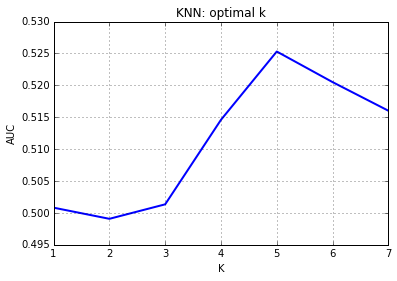

In [23]:
t0 = time.clock()

from sklearn.neighbors import KNeighborsClassifier

X = X_train
y = y_train
# search for an optimal value of K for KNN
k_range = range(1, 8)
k_val = []
for k in k_range:
   knn = KNeighborsClassifier(n_neighbors=k)
   scores = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
   k_val.append(scores.mean())
print k_val

# plot the values of K for KNN 
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_range, k_val, linewidth=2.0)
plt.xlabel('K ')
plt.ylabel('AUC')
plt.title('KNN: optimal k')
plt.grid(True)

# use optimal k
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
knn_pred_rating = knn.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
knn_10cv_auc = cross_val_score(knn, X, y, cv=10, scoring='roc_auc')
print knn_10cv_auc
print knn_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
knn_time=time.clock() - t0

> 5.3 Logistic Regression

In [24]:
# measure process time
t0 = time.clock()

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print lg_10cv_auc
print lg_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
lg_time=time.clock() - t0

[ 0.55928728  0.44501597  0.57543667  0.58076791  0.51673554  0.54881198
  0.56394628  0.59230372  0.4710916   0.4934573 ]
0.534685423552
0.371385145282 seconds process time


> 5.4 Tree

[0.5048798117330644, 0.5104502232474657, 0.51007177051772012, 0.52249344201886838, 0.51520609148144914, 0.50159913413463486, 0.4945785987019139, 0.50289764478785937]
[ 0.5422592   0.54338544  0.59147641  0.57501722  0.46866391  0.50809229
  0.46893939  0.52377755  0.51470386  0.48861915]
0.522493442019
1.02566317051 seconds process time


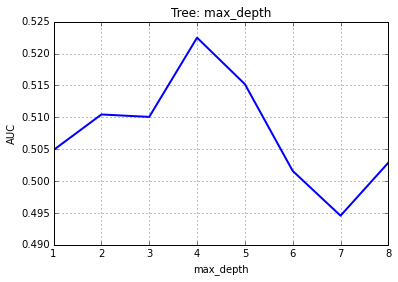

In [25]:
import time
# measure process time
t0 = time.clock()

X = X_train
y = y_train

# optimal depth
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
depth = range(1, 9)
treedepth = []
for d in depth:
    tree= DecisionTreeClassifier(max_depth = d, random_state =1)
    scores = cross_val_score(tree, X, y, cv=10, scoring='roc_auc')
    treedepth.append(scores.mean())
print treedepth
# plot the values of n for depth
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(depth, treedepth, linewidth=2.0)
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.title('Tree: max_depth')
plt.grid(True)

tree = DecisionTreeClassifier(max_depth=4, random_state=1)

tree.fit(X,y)
from sklearn.cross_validation import cross_val_score
tree_10cv_auc = cross_val_score(tree, X, y, cv=10, scoring='roc_auc')
print tree_10cv_auc
print tree_10cv_auc.mean()


print time.clock() - t0, "seconds process time"
tree_time=time.clock() - t0

> 5.5 Bagging

[0.52145381489909404, 0.52423830954990702, 0.53044799876081683, 0.53228497844626976, 0.53177554495581592, 0.53089699081309594, 0.53104816734252158, 0.53118299016155235, 0.53208847865256881, 0.53210452673482167, 0.53140264215528965]
199.028599459 seconds process time


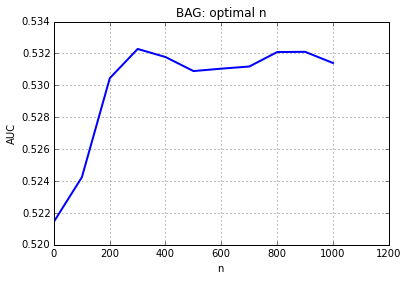

In [26]:
# measure process time
t0 = time.clock()

from sklearn.ensemble import BaggingClassifier
X = X_train
y = y_train

#Find the best no of estimators
bag_n=range(1, 1100, 100)
bag_auc_val= []
for n in bag_n:
    bag=BaggingClassifier(tree,n_estimators=n, random_state=1)
    bag_10cv_auc = cross_val_score(bag, X, y, cv=10, scoring='roc_auc')
    bag_auc_val.append(bag_10cv_auc.mean())
print bag_auc_val

# plot the values of n for Bag 
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bag_n, bag_auc_val, linewidth=2.0)
plt.xlabel('n ')
plt.ylabel('AUC')
plt.title('BAG: optimal n')
plt.grid(True)

print time.clock() - t0, "seconds process time"
bag_time=time.clock() - t0

In [27]:
# measure process time
t0 = time.clock()
# use optimal n
bag=BaggingClassifier(tree,n_estimators=300, random_state=1)
bag.fit(X,y)
from sklearn.cross_validation import cross_val_score
bag_10cv_auc=cross_val_score(bag, X, y, cv=10, scoring='roc_auc')
print bag_10cv_auc
print bag_10cv_auc.mean()

print time.clock() - t0, "seconds process time"
bag_time=time.clock() - t0

[ 0.60171457  0.52247437  0.54373539  0.56585744  0.5184573   0.51964532
  0.51663223  0.55430441  0.49524793  0.48302342]
0.532109237055
12.0274076769 seconds process time


5.6 Random Forest

[0.49873936205682179, 0.4732523679234929, 0.47831310022936002, 0.48020052852830331, 0.47612558416651735, 0.47851599216619506, 0.47863656941440269, 0.47889389875928856, 0.47857288588678698, 0.47929764742737513, 0.47927322148732543]
173.516458402 seconds process time


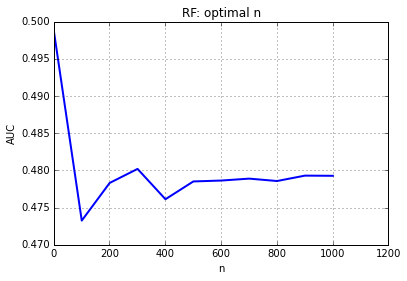

In [28]:
# measure process time
t0 = time.clock()

from sklearn.ensemble import RandomForestClassifier
X = X_train
y = y_train

#Find the best no of estimators
rf_n=range(1, 1100, 100)
rf_auc_val= []
for n in rf_n:
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf_10cv_auc = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
    rf_auc_val.append(rf_10cv_auc.mean())
print rf_auc_val

# plot the no of estimators vc cv_auc
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rf_n, rf_auc_val, linewidth=2.0)
plt.xlabel('n')
plt.ylabel('AUC')
plt.title('RF: optimal n')
plt.grid(True)    

print time.clock() - t0, "seconds process time"
rf_time=time.clock() - t0

In [29]:
# measure process time
t0 = time.clock()
# use optimal n
rf = RandomForestClassifier(n_estimators=1, random_state=1)
rf.fit(X,y)
from sklearn.cross_validation import cross_val_score
rf_10cv_auc = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
print rf_10cv_auc
print rf_10cv_auc.mean()


print time.clock() - t0, "seconds process time"
rf_time=time.clock() - t0

[ 0.49934443  0.50706001  0.50168478  0.56287879  0.47661846  0.51680441
  0.48419421  0.49480028  0.46742424  0.47658402]
0.498739362057
0.101587081174 seconds process time


> 5.7 SVM Polynomial

In [ ]:
# measure process time
#t0 = time.clock()@#

#from sklearn import svm
#svmp = svm.SVC(kernel='poly', C = 1.0, degree=3)
#X = X_train
#y = y_train
#svmp.fit(X,y)
#from sklearn.cross_validation import cross_val_score
#svmp_10cv_auc = cross_val_score(svmp, X, y, cv=10, scoring='roc_auc')
#print svmp_10cv_auc
#svmp_10cv_auc.mean()

#print time.clock() - t0, "seconds process time"
#svmp_time=time.clock() - t0

> 5.8 SVM Gaussian

In [ ]:
# measure process time
#t0 = time.clock()

#from sklearn import svm
#svmg = svm.SVC(kernel='rbf', C = 1.0, gamma=0.5)
#X = X_train
#y = y_train
#svmg.fit(X,y)
#from sklearn.cross_validation import cross_val_score
#svmg_10cv_auc = cross_val_score(svmg, X, y, cv=10, scoring='roc_auc')
#print svmg_10cv_auc
#svmg_10cv_auc.mean()


#print time.clock() - t0, "seconds process time"
#svmg_time=time.clock() - t0

> 5.9 Tabulate 10cv_auc_means & time

In [30]:
print 'NB 10CV AUC.mean & process time'
print nb_10cv_auc.mean()
print nb_time
print 'KNN 10CV AUC.mean & process time'
print knn_10cv_auc.mean()
print knn_time
print 'LG 10CV AUC.mean & process time'
print lg_10cv_auc.mean()
print lg_time
print 'TREE 10CV AUC.mean & process time'
print tree_10cv_auc.mean()
print tree_time
print 'BAG 10CV AUC.mean & process time'
print bag_10cv_auc.mean()
print bag_time
print 'RF 10CV AUC.mean & process time'
print rf_10cv_auc.mean()
print rf_time
print 'SVMG 10CV AUC.mean & process time'
#print svmp_10cv_auc.mean()
#print svmp_time
print 'SVMP 10CV AUC.mean & process time'
#print svmg_10cv_auc.mean()
#print svmg_time


NB 10CV AUC.mean & process time
0.533662477477
0.116865322239
KNN 10CV AUC.mean & process time
0.525307021702
1.07491596696
LG 10CV AUC.mean & process time
0.534685423552
0.371436463171
TREE 10CV AUC.mean & process time
0.522493442019
1.02571207344
BAG 10CV AUC.mean & process time
0.532109237055
12.027458391
RF 10CV AUC.mean & process time
0.498739362057
0.101634172884
SVMG 10CV AUC.mean & process time
SVMP 10CV AUC.mean & process time


0.53257156907
0.507173520108
0.545921825576
0.480541120651
0.488289452699
0.495529425055
0.18438517396 seconds process time


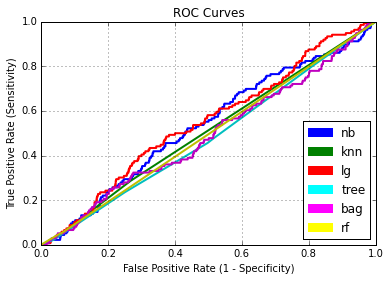

In [31]:
# measure process time
t0 = time.clock()

# If not, use the following; adds also more features....
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
# NB:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
nb_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
nb_fpr, nb_tpr, nb_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# KNN:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
knn_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# LG:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
logreg_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
lg_fpr, lg_tpr, lg_thresholds = metrics.roc_curve(y_test, y_pred_prob)
#TREE:
y_pred_prob = tree.predict_proba(X_test)[:, 1]
tree_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
tree_fpr, tree_tpr, tree_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# BAG:
y_pred_prob = bag.predict_proba(X_test)[:, 1]
bag_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
bag_fpr, bag_tpr, bag_thresholds = metrics.roc_curve(y_test, y_pred_prob)
# RF:
y_pred_prob = rf.predict_proba(X_test)[:, 1]
rf_auc=metrics.roc_auc_score(y_test, y_pred_prob)
print metrics.roc_auc_score(y_test, y_pred_prob)
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(nb_fpr, nb_tpr, knn_fpr, knn_tpr, lg_fpr, lg_tpr, tree_fpr, tree_tpr, bag_fpr, bag_tpr,rf_fpr, rf_tpr, linewidth=2.0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curves')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
nb = mpatches.Patch(color='blue', label='nb')
knn= mpatches.Patch(color='green', label='knn')
lg = mpatches.Patch(color='red', label='lg')
tree = mpatches.Patch(color='cyan', label='tree')
bag = mpatches.Patch(color='magenta', label='bag')
rf = mpatches.Patch(color='yellow', label='rf')
plt.legend(handles=[nb,knn,lg,tree,bag,rf], loc=4)
plt.grid(True)


print time.clock() - t0, "seconds process time"
plot_time=time.clock() - t0


> 5.10 Feature selection
> 
> Recursive feature elimination: recursively removing attributes and building a model on those attributes that remain. 
> It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most 
> to predicting the target attribute.

In [32]:
# Recursive Feature Elimination 3 vars
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
X = X_train
y = y_train
X.shape
model = LogisticRegression()
rfe = RFE(model, 3)
rfe=rfe.fit(X,y)
# summarize the selection of the attributes
print 'Best three features:'
print(rfe.support_)
print(rfe.ranking_)
X_train.head()

# Recursive Feature Elimination 2 vars
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
X = X_train
y = y_train
X.shape
model = LogisticRegression()
rfe = RFE(model, 2)
rfe=rfe.fit(X,y)
# summarize the selection of the attributes
print 'Best two features:'
print(rfe.support_)
print(rfe.ranking_)
X_train.head()

# Recursive Feature Elimination 1 var
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
X = X_train
y = y_train
X.shape
model = LogisticRegression()
rfe = RFE(model, 1)
rfe=rfe.fit(X,y)
# summarize the selection of the attributes
print 'Best one feature:'
print(rfe.support_)
print(rfe.ranking_)
X_train.head()

Best three features:
[False False False False False  True  True  True]
[5 6 3 2 4 1 1 1]
Best two features:
[False False False False False  True False  True]
[6 7 4 3 5 1 2 1]
Best one feature:
[False False False False False  True False False]
[7 8 5 4 6 1 3 2]


,recency,history,mens,womens,Location,newbie,Purchase_channel,Campaign_type
29814,10,150.07,0,1,0,0,0,1
56302,1,204.46,1,1,0,0,1,1
10971,8,509.23,1,0,2,1,1,1
11511,3,103.85,1,0,2,1,1,0
21048,5,29.99,0,1,2,0,0,1


In [33]:
df2=df[(df.visit==1)]
X_cols=[ 'recency', 'history', 'mens', 'womens', 'Location', 'newbie', 'Purchase_channel', 'Campaign_type']
X=df2[X_cols]
Y=df2.conversion

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)
#-----------------------------------------------------------------------------
# Logistic Regression: all prediction variables
#-----------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print 'LG with all seven predictors:'
print lg_10cv_auc
print lg_10cv_auc.mean()

#-----------------------------------------------------------------------------
# Logistic Regression: best 2 variables
#-----------------------------------------------------------------------------

X_cols=[ 'newbie',  'Campaign_type']
X=df2[X_cols]
Y=df2.conversion

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print "LG with best two predictors:"
print lg_10cv_auc
print lg_10cv_auc.mean()


LG with all seven predictors:
[ 0.55928728  0.44501597  0.57543667  0.58076791  0.51673554  0.54881198
  0.56394628  0.59230372  0.4710916   0.4934573 ]
0.534685423552
LG with best two predictors:
[ 0.51280888  0.46927215  0.5277816   0.60148072  0.52923554  0.55072314
  0.57190083  0.53254132  0.54987948  0.50027548]
0.534589912153


#### 6. Objective 3: develop a regression model to predict how much customers spent in the past two weeks

In [34]:
df3=df2[(df2.conversion==1)]
# Regression
# create dummy variables for location purchase_channel and campaign type
location_dummies=pd.get_dummies(df3.Location, prefix='location')
location_dummies=location_dummies[['location_1','location_2']]
df4=pd.concat([df3,location_dummies], axis=1)

pc_dummies=pd.get_dummies(df3.Purchase_channel, prefix='purchase_channel')
pc_dummies=pc_dummies[['purchase_channel_1','purchase_channel_2']]
df4=pd.concat([df4,pc_dummies], axis=1)

ct_dummies=pd.get_dummies(df3.Campaign_type, prefix='campaign')
ct_dummies=ct_dummies[['campaign_1','campaign_2']]
df4=pd.concat([df4,ct_dummies], axis=1)

print 'Recency: Months since last purchase'
print 'History: Actual dollar value spent in the past year'
print 'Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year'
print 'Newbie: 1/0 indicator, 1 = New customer in the past twelve months'
print 'Location: Surburban: 0, Rural: 1, Urban: 2'
print 'Purchase_channel: Phone: 0, Web: 1, Multichannel: 2'
print 'Campaign_type: NoEMail: 0, WomensEMail: 1, MensEMail:2' 

feature_cols = ['recency','history','womens','newbie','location_1','location_2','purchase_channel_1','purchase_channel_2','campaign_1','campaign_2' ]
X = df4[feature_cols]
y = df4.spend
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)
print zip(feature_cols, linreg.coef_)

# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf
lm = smf.ols(formula='spend ~recency+history+mens+womens+newbie+location_1+location_2+purchase_channel_1+purchase_channel_2+campaign_1+campaign_2', data=df4).fit()
print lm.summary() 

Recency: Months since last purchase
History: Actual dollar value spent in the past year
Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year
Newbie: 1/0 indicator, 1 = New customer in the past twelve months
Location: Surburban: 0, Rural: 1, Urban: 2
Purchase_channel: Phone: 0, Web: 1, Multichannel: 2
Campaign_type: NoEMail: 0, WomensEMail: 1, MensEMail:2
[('recency', 0.68780147364098743), ('history', 0.0092757886070461044), ('womens', -27.057115494324762), ('newbie', 1.9415417429206636), ('location_1', -15.007073387127351), ('location_2', -3.7684544934566486), ('purchase_channel_1', 1.4026193026304892), ('purchase_channel_2', -6.0982017274315492), ('campaign_1', 10.46600526644394), ('campaign_2', -1.2860940399438583)]
                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.001
Method

#### 7. Notes: 
> 'accuracy' vs. 'roc_auc' (cross_val_score(..., X, y, cv=..., scoring='accuracy' or 'roc_auc'))

In [35]:
X_cols=[ 'recency', 'history', 'mens','womens', 'Location', 'newbie', 'Purchase_channel', 'Campaign_type']
X=df[X_cols]
Y=df.visit
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1234567)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
X = X_train
y = y_train
logreg.fit(X, y)
lg_pred_rating = logreg.predict(X) # class predictions
from sklearn import metrics
# print metrics.accuracy_score(y_test, y_pred_rating)
# 10 fold cross-validation
from sklearn.cross_validation import cross_val_score
lg_10cv_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print 'AUC values'
print lg_10cv_auc
print lg_10cv_auc.mean()

AUC values
[ 0.64243634  0.64564644  0.64579946  0.61983594  0.61726966  0.62933077
  0.6477608   0.6452407   0.64036973  0.63627114]
0.636996097985


In [36]:
from sklearn.cross_validation import cross_val_score
lg_10cv_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print 'Accuracy values'
print lg_10cv_accuracy
print lg_10cv_accuracy.mean()

Accuracy values
[ 0.85273901  0.85273901  0.85291667  0.85291667  0.85291667  0.85291667
  0.85291667  0.85291667  0.85288602  0.85288602]
0.852875006125


In [37]:
print len(df.visit[(df.visit==1)])
print len(df.visit[(df.visit==0)])

9394
54606


In [38]:
54606.0/(54606+9394)

0.85321875

$Accuracy=\dfrac{(Predicted TRUE|TRUE)+(Predicted FALSE|FALSE)}{TOTAL}$

$Sensitivity=\dfrac{Predicted TRUE|TRUE}{TOTAL TRUE}$

$Specificity=\dfrac{Predicted FALSE|FALSE}{TOTAL FALSE}$

$1-Specificity=\dfrac{Predicted TRUE|FALSE}{TOTAL FALSE}$

> AUC - area under the ROC: Sensitivity (TPR) vs. (1-Specificity)(FPR)

> Accuracy  measures the proportion of the total number of predictions that are correct.
>
> AUC measures the quality of the the classification. Given a random sample of positive & negative observations, AUC gives 
> the proportion of the times your model guesses which is correct.
>
> Accuracy is sensitive to the sample balance (AUC less affected...)

> Most MLM are sensitive to the initial labeled dataset & skewness of the data...

#### 8. Conclusions:

> Response variable:
>
>    - Visit: 
>          - Best models: loggistic regression, tree and bagging: AUC ~0.64-0.65 
>          - Best features: if customers purchased mens & womens products in the past
>    - Conversion: 
>          - Best models: naive bayes & logistic regression: AUC ~0.53-0.55
>          - Tree, bagging & random forest performe worst than the null model <0.5
>          - Best features: newbie & campaign type
>    - Spend:
>          - Regression analysis: no predictive power & major assumption violations
>Note: since the data is unbalanced,AUC is better suited to asses model performance than accuracy